# Introduction

In preceding notebooks, performed preliminary assessments of data quality and refined the question to be answered. You found a small number of data values that gave clear choices about whether to replace values or drop a whole row. You determined that predicting the adult weekend ticket price was your primary aim. You threw away records with missing price data, but not before making the most of the other available data to look for any patterns between the states. You didn't see any and decided to treat all states equally; the state label didn't seem to be particularly useful.

In this notebook you'll start to build machine learning models. Before even starting with learning a machine learning model, however, start by considering how useful the mean value is as a predictor. This is more than just a pedagogical device. You never want to go to stakeholders with a machine learning model only to have the CEO point out that it performs worse than just guessing the average! Your first model is a baseline performance comparitor for any subsequent model. You then build up the process of efficiently and robustly creating and assessing models against it. The development we lay out may be little slower than in the real world, but this step of the capstone is definitely more than just instructional. It is good practice to build up an understanding that the machine learning pipelines you build work as expected. You can validate steps with your own functions for checking expected equivalence between, say, pandas and sklearn implementations.

# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statistics
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
import joblib
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, cross_validate, learning_curve, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale

In [5]:
from numpy.random import default_rng
RANDOM_SEED = 51
rng = default_rng(RANDOM_SEED)

# Load Data

In [6]:
ski_data = pd.read_csv("../data/ski_data_features.csv")
ski_data.head()

,adult_weekday,adult_weekend,average_snowfall,base_elev,daysopenlast_year,double,fast_quads,fast_sixes,longest_run_mi,name,...,resorts_per_100kcapita,resorts_per_100ksq_mile,resort_skiable_area_ac_state_ratio,resort_days_open_state_ratio,resort_terrain_park_state_ratio,resort_night_skiing_state_ratio,total_chairs_runs_ratio,total_chairs_skiable_ratio,fastQuads_runs_ratio,fastQuads_skiable_ratio
0,65.0,85.0,669.0,250,150.0,0,2,0,1.0,alyeska_resort,...,0.410091,0.450867,0.706140,0.434783,0.500000,0.948276,0.092105,0.004348,0.026316,0.001242
1,47.0,53.0,350.0,1200,45.0,4,0,0,2.0,eaglecrest_ski_area,...,0.410091,0.450867,0.280702,0.130435,0.250000,NaN,0.111111,0.006250,0.000000,0.000000
2,30.0,34.0,69.0,1796,150.0,0,0,0,1.0,hilltop_ski_area,...,0.410091,0.450867,0.013158,0.434783,0.250000,0.051724,0.230769,0.100000,0.000000,0.000000
3,89.0,89.0,260.0,9200,122.0,1,0,1,2.0,arizona_snowbowl,...,0.027477,1.754540,0.492708,0.514768,0.666667,NaN,0.145455,0.010296,0.000000,0.000000
4,74.0,78.0,250.0,9200,115.0,1,1,0,1.2,sunrise_park_resort,...,0.027477,1.754540,0.507292,0.485232,0.333333,1.000000,0.107692,0.008750,0.015385,0.001250


## Extract Big Mountain Data

Big Mountain is your resort. Separate it from the rest of the data to use later.

In [7]:
target_resort = "big_mountain_resort"
big_mountain = ski_data[ski_data.name == target_resort]

In [8]:
big_mountain.T

,121
adult_weekday,81.0
adult_weekend,81.0
average_snowfall,333.0
base_elev,4464
daysopenlast_year,123.0
double,0
fast_quads,3
fast_sixes,0
longest_run_mi,3.3
name,big_mountain_resort


In [9]:
ski_data.shape

(270, 42)

In [10]:
ski_data = ski_data[ski_data.name != target_resort]

In [11]:
ski_data.shape

(269, 42)

## Train/Test Split

So far, you've treated ski resort data as a single entity. In machine learning, when you train your model on all of your data, you end up with no data set aside to evaluate model performance. You could keep making more and more complex models that fit the data better and better and not realise you were overfitting to that one set of samples. By partitioning the data into training and testing splits, without letting a model (or missing-value imputation) learn anything about the test split, you have a somewhat independent assessment of how your model might perform in the future. An often overlooked subtlety here is that people all too frequently use the test set to assess model performance _and then compare multiple models to pick the best_. This means their overall model selection process is  fitting to one specific data set, now the test split. You could keep going, trying to get better and better performance on that one data set, but that's  where cross-validation becomes especially useful. While training models, a test split is very useful as a final check on expected future performance.

What partition sizes would you have with a 70/30 train/test split?

In [12]:
len(ski_data) * 0.7, len(ski_data) * 0.3

(188.29999999999998, 80.7)

<div class="alert alert-block alert-warning">
<b>MY CUSTOM ADDITION</b></div>

Remember when I advised not dropping the ticket price columns? You will want to rid yourself of them now. Why? 

1. Recall the tight linear relationship between `adult_weekend` and `adult_weekday`? Since `adult_weekend` is our target variable, the one we want to predict, if you build a model with `adult_weekday` included as a feature, you should end up with a model that finds the linear relationship between the two and ignores most other features.
2. The field `price_delta` is calculated using `adult_weekend` the target variable. If `price_delta` is left in as a feature, that's called "future information" or "data leakage" and the model gets to cheat because you've given it the answer: `adult_weekend` == `adult_weekday` +/- `price_delta`.

As an experiment, leave these fields in and see what happens.

In [13]:
# drop columsn containing future information
target_col = "adult_weekend"
drop_cols = ["adult_weekday", "price_delta", target_col]

<div class="alert alert-block alert-warning">
<b></b></div>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    ski_data.drop(columns=drop_cols),
    ski_data[target_col],
    test_size=0.3,
    random_state=RANDOM_SEED,
)

In [15]:
X_train.shape, X_test.shape

((188, 39), (81, 39))

In [16]:
y_train.shape, y_test.shape

((188,), (81,))

In [17]:
# Code task 1 #
# Save the 'Name', 'state', and 'Region' columns from the train/test data into names_train and names_test
# Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = ["name", "state", "region"]
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((188, 36), (81, 36))

In [18]:
# Code task 2 #
# Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

average_snowfall                      float64
base_elev                               int64
daysopenlast_year                     float64
double                                  int64
fast_quads                              int64
fast_sixes                              int64
longest_run_mi                        float64
night_skiing_ac                       float64
projecteddays_open                    float64
quad                                    int64
runs                                  float64
skiable_terrain_ac                    float64
snow_making_ac                        float64
summit_elev                             int64
surface                                 int64
terrain_parks_resort                  float64
total_chairs                            int64
trams                                   int64
triple                                  int64
vertical_drop                           int64
years_open                            float64
resort_cnt                        

In [19]:
# Code task 3#
# Repeat this check for the test split in `X_test`
X_test.dtypes

average_snowfall                      float64
base_elev                               int64
daysopenlast_year                     float64
double                                  int64
fast_quads                              int64
fast_sixes                              int64
longest_run_mi                        float64
night_skiing_ac                       float64
projecteddays_open                    float64
quad                                    int64
runs                                  float64
skiable_terrain_ac                    float64
snow_making_ac                        float64
summit_elev                             int64
surface                                 int64
terrain_parks_resort                  float64
total_chairs                            int64
trams                                   int64
triple                                  int64
vertical_drop                           int64
years_open                            float64
resort_cnt                        

You have only numeric features in your X now!

# Initial Naive Model

A good place to start is to see how good the mean is as a predictor. In other words, what if you simply say your best guess is the average price?

In [20]:
# Code task 4#
# Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

64.66244680851064

`sklearn`'s `DummyRegressor` easily does this:

In [21]:
# Code task 5#
# Fit the dummy regressor on the training data
# Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
# Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy="mean")
dumb_reg.fit(X_train, y_train)
assert dumb_reg.constant_ == train_mean, "Something is wrong"
print(dumb_reg.constant_)

[[64.66244681]]


How good is this? How closely does this match, or explain, the actual values? There are many ways of assessing how good one set of values agrees with another, which brings us to the subject of metrics.

## Performance Metrics

### R-squared

One measure is $R^2$, the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). This is a measure of the proportion of variance in the dependent variable (our ticket price) that is predicted by our "model". The linked Wikipedia articles gives a nice explanation of how negative values can arise. This is frequently a cause of confusion for newcomers who, reasonably, ask how can a squared value be negative?

Recall the mean can be denoted by $\bar{y}$, where

$$\bar{y} = \frac{1}{n}\sum_{i=1}^ny_i$$

and where $y_i$ are the individual values of the dependent variable.

The total sum of squares (error), can be expressed as

$$SS_{tot} = \sum_i(y_i-\bar{y})^2$$

The above formula should be familiar as it's simply the variance without the denominator to scale (divide) by the sample size.

The residual sum of squares is similarly defined to be

$$SS_{res} = \sum_i(y_i-\hat{y})^2$$

where $\hat{y}$ are our predicted values for the depended variable.

The coefficient of determination, $R^2$, here is given by

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Putting it into words, it's one minus the ratio of the residual variance to the original variance. Thus, the baseline model here, which always predicts $\bar{y}$, should give $R^2=0$. A model that perfectly predicts the observed values would have no residual error and so give $R^2=1$. Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative $R^2$.

In [22]:
# Code task 6#
# Calculate the R^2 as defined above
def r_squared(y, ypred):
    """R-squared score.

    Calculate the R-squared, or coefficient of determination, of the input.

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y)  # yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar) ** 2)  # total sum of squares error
    sum_sq_res = np.sum((y - ypred) ** 2)  # residual sum of squares error
    R2 = 1.0 - (sum_sq_res / sum_sq_tot)
    return R2

Make your predictions by creating an array of length the size of the training set with the single value of the mean.

In [23]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([64.66244681, 64.66244681, 64.66244681, 64.66244681, 64.66244681])

Remember the `sklearn` dummy regressor? 

In [24]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([64.66244681, 64.66244681, 64.66244681, 64.66244681, 64.66244681])

You can see that `DummyRegressor` produces exactly the same results and saves you having to mess about broadcasting the mean (or whichever other statistic we used - check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) to see what's available) to an array of the appropriate length. It also gives you an object with `fit()` and `predict()` methods as well so you can use them as conveniently as any other `sklearn` estimator.

In [25]:
r_squared(y_train, y_tr_pred)

0.0

Exactly as expected, if you use the average value as your prediction, you get an $R^2$ of zero _on our training set_. What if you use this "model" to predict unseen values from the test set? Remember, of course, that your "model" is trained on the training set; you still use the training set mean as your prediction.

Make your predictions by creating an array of length the size of the test set with the single value of the (training) mean.

In [26]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-2.2991887115519916e-05

Generally, you can expect performance on a test set to be slightly worse than on the training set. As you are getting an $R^2$ of zero on the training set, there's nowhere to go but negative!

$R^2$ is a common metric, and interpretable in terms of the amount of variance explained, it's less appealing if you want an idea of how "close" your predictions are to the true values. Metrics that summarise the difference between predicted and actual values are _mean absolute error_ and _mean squared error_.

### Mean Absolute Error

This is very simply the average of the absolute errors:

$$MAE = \frac{1}{n}\sum_i^n|y_i - \hat{y}|$$

In [27]:
# Code task 7#
# Calculate the MAE as defined above
def mae(y, ypred):
    """Mean absolute error.

    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [28]:
mae(y_train, y_tr_pred)

18.02853214124038

In [29]:
mae(y_test, y_te_pred)

19.172370633044395

Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around \\$19 if you guessed ticket price based on an average of known values.

### Mean Squared Error

Another common metric (and an important one internally for optimizing machine learning models) is the mean squared error. This is simply the average of the square of the errors:

$$MSE = \frac{1}{n}\sum_i^n(y_i - \hat{y})^2$$

In [30]:
# Code task 8#
# Calculate the MSE as defined above
def mse(y, ypred):
    """Mean square error.

    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred) ** 2
    mse = np.mean(sq_error)
    return mse

In [31]:
mse(y_train, y_tr_pred)

623.1549716727023

In [32]:
mse(y_test, y_te_pred)

578.5318197509905

So here, you get a slightly better MSE on the test set than you did on the train set. And what does a squared error mean anyway? To convert this back to our measurement space, we often take the square root, to form the _root mean square error_ thus:

In [33]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([24.96307216, 24.05268841])

### sklearn metrics

Functions are good, but you don't want to have to define functions every time we want to assess performance. `sklearn.metrics` provides many commonly used metrics, included the ones above.

In [34]:
print(f'R2 {r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)}')
print(f'MAE {mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)}')
print(f'MSE {mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)}')

R2 (0.0, -2.2991887115519916e-05)
MAE (18.02853214124038, 19.17237063304439)
MSE (623.1549716727026, 578.5318197509906)


## Note On Calculating Metrics

When calling functions to calculate metrics, it is important to take care in the order of the arguments. Two of the metrics above actually don't care if the arguments are reversed; one does. Which one cares?

In a Jupyter code cell, running `r2_score?` will bring up the docstring for the function, and `r2_score??` will bring up the actual code of the function! Try them and compare the source for `sklearn`'s function with yours. Feel free to explore what happens when you reverse the order of the arguments and compare behaviour of `sklearn`'s function and yours.

In [35]:
# train set - sklearn
# correct order, incorrect order
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, 0.0)

In [36]:
# test set - sklearn
# correct order, incorrect order
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-2.2991887115519916e-05, 0.0)

In [37]:
# train set - using our homebrew function
# correct order, incorrect order
r_squared(y_train, y_tr_pred), r_squared(y_tr_pred, y_train)

/tmp/ipykernel_634107/2193220549.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1.0 - (sum_sq_res / sum_sq_tot)


(0.0, -inf)

In [38]:
# test set - using our homebrew function
# correct order, incorrect order
r_squared(y_test, y_te_pred), r_squared(y_te_pred, y_test)

/tmp/ipykernel_634107/2193220549.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1.0 - (sum_sq_res / sum_sq_tot)


(-2.2991887115519916e-05, -inf)

You can get very different results swapping the argument order. It's worth highlighting this because data scientists do this too much in the real world! Don't be one of them! Frequently the argument order doesn't matter, but it will bite you when you do it with a function that does care. It's sloppy, bad practice and if you don't make a habit of putting arguments in the right order, you will forget!

Remember:
* argument order matters,
* check function syntax with `func?` in a code cell

# Initial Linear Model

Recall when performing EDA, you imputed (filled in) some missing values in pandas. You did this judiciously for exploratory/visualization purposes. You left many missing values in the data. You can impute missing values using scikit-learn, but note that you should learn values to impute from a train split and apply that to the test split to then assess how well your imputation worked.

## Impute missing values with median

There's missing values. Recall from your data exploration that many distributions were skewed. Your first thought might be to impute missing values using the median.

In [39]:
# These are the values we'll use to fill in any missing values
X_defaults_median = X_train.median()
X_defaults_median

average_snowfall                       125.000000
base_elev                             1325.000000
daysopenlast_year                      110.000000
double                                   1.000000
fast_quads                               0.000000
fast_sixes                               0.000000
longest_run_mi                           1.000000
night_skiing_ac                         72.500000
projecteddays_open                     117.000000
quad                                     0.500000
runs                                    31.000000
skiable_terrain_ac                     176.500000
snow_making_ac                         100.000000
summit_elev                           2225.000000
surface                                  2.000000
terrain_parks_resort                     2.000000
total_chairs                             7.000000
trams                                    0.000000
triple                                   1.000000
vertical_drop                          812.500000


In [40]:
# Code task 9 #
# Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
# Assign the results to `X_tr` and `X_te`, respectively
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

### Scale the data

As you have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scales each feature to zero mean and unit variance.

In [41]:
# Code task 10#
# Call the StandardScaler`s fit method on `X_tr` to fit the scaler
# then use it's `transform()` method to apply the scaling to both the train and test split
# data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

### Train the model on the train split

In [42]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

### Make predictions using the model on both train and test splits

In [43]:
# Code task 11#
# Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
# Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

### Assess model performance

In [44]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.8412891552865114, 0.7187495103407981)

Recall that you estimated ticket price by simply using a known average. As expected, this produced an $R^2$ of zero for both the training and test set, because $R^2$ tells us how much of the variance you're explaining beyond that of using just the mean, and you were using just the mean. Here we see that our simple linear regression model explains over 80% of the variance on the train set and over 70% on the test set. Clearly you are onto something, although the much lower value for the test set suggests you're overfitting somewhat. This isn't a surprise as you've made no effort to select a parsimonious set of features or deal with multicollinearity in our data.

In [45]:
# Code task 12#
# Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(7.848625004322187, 9.311873995554036)

Using this model, then, on average you'd expect to estimate a ticket price within \\$9 or so of the real price. This is much, much better than the \\$19 from just guessing using the average. There may be something to this machine learning lark after all!

In [46]:
# Code task 13#
# And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(98.90145194158468, 162.70861661024935)

## Impute missing values with mean

You chose to use the median for filling missing values because of the skew of many of our predictor feature distributions. What if you wanted to try something else, such as the mean?

In [47]:
# Code task 14#
# As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

average_snowfall                       171.618785
base_elev                             3111.728723
daysopenlast_year                      112.043478
double                                   1.845745
fast_quads                               0.760638
fast_sixes                               0.095745
longest_run_mi                           1.324865
night_skiing_ac                         94.132075
projecteddays_open                     117.208589
quad                                     0.973404
runs                                    42.602151
skiable_terrain_ac                     513.478495
snow_making_ac                         142.445122
summit_elev                           4230.728723
surface                                  2.420213
terrain_parks_resort                     2.645570
total_chairs                             7.712766
trams                                    0.122340
triple                                   1.494681
vertical_drop                         1107.063830


By eye, you can immediately tell that your replacement values are much higher than those from using the median.

<div class="alert alert-block alert-info">
<b>MY CUSTOM ADDITION</b> When doing something "by-eye" best to show it.</div>

In [48]:
round(100 * (X_defaults_mean - X_defaults_median) / X_defaults_median, 0).sort_values()

terrain_parks_state                    -2.0
years_open                             -1.0
projecteddays_open                      0.0
daysopenlast_year                       2.0
days_open                               2.0
resort_cnt                              6.0
total_chairs                           10.0
surface                                21.0
night_skiing_ac                        30.0
terrain_parks_resort                   32.0
longest_run_mi                         32.0
vertical_drop                          36.0
average_snowfall                       37.0
runs                                   37.0
total_chairs_runs_ratio                37.0
snow_making_ac                         42.0
triple                                 49.0
nightskiing_ac                         54.0
total_chairs_skiable_ratio             57.0
resort_days_open_state_ratio           61.0
resort_terrain_park_state_ratio        75.0
resorts_per_100kcapita                 76.0
resort_night_skiing_state_ratio 

<div class="alert alert-block alert-info">
<b></b></div>

In [49]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

### Scale the data

In [50]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

### Train the model on the train split

In [51]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

### Make predictions using the model on both train and test splits

In [52]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

### Assess model performance

In [53]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8399941566572605, 0.724160958792183)

In [54]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(7.866253121620914, 9.27279086247017)

In [55]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(99.70843677571173, 159.5779934691149)

These results don't seem very different to when you used the median for imputing missing values. Perhaps it doesn't make much difference here. Maybe your overtraining dominates. Maybe other feature transformations, such as taking the log, would help. You could try with just a subset of features rather than using all of them as inputs.

To perform the median/mean comparison, you copied and pasted a lot of code just to change the function for imputing missing values. It would make more sense to write a function that performed the sequence of steps:
1. impute missing values
2. scale the features
3. train a model
4. calculate model performance

But these are common steps and `sklearn` provides something much better than writing custom functions.

## Pipelines

One of the most important and useful components of `sklearn` is the [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). In place of `panda`'s `fillna` DataFrame method, there is `sklearn`'s `SimpleImputer`. Remember the first linear model above performed the steps:

1. replace missing values with the median for each feature
2. scale the data to zero mean and unit variance
3. train a linear regression model

and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant `Pipeline` object has a `fit()` method and a `predict()` method, just like the `LinearRegression()` object itself. Just as you might create a linear regression model and train it with `.fit()` and predict with `.predict()`, you can wrap the entire process of imputing and feature scaling and regression in a single object you can train with `.fit()` and predict with `.predict()`. And that's basically a pipeline: a model on steroids.

### Define a pipeline

In [56]:
pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LinearRegression()
)

In [57]:
type(pipe)

sklearn.pipeline.Pipeline

In [58]:
hasattr(pipe, "fit"), hasattr(pipe, "predict")

(True, True)

### Fit the pipeline

Here, a single call to the pipeline's `fit()` method combines the steps of learning the imputation (determining what values to use to fill the missing ones), the scaling (determining the mean to subtract and the variance to divide by), and then training the model. It does this all in the one call with the training data as arguments.

In [59]:
# Code task 15 #
# Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### Make predictions

In [60]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

### Assess performance

In [61]:
pipe_median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
pipe_median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
pipe_median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

In [62]:
# R2
print(f'Pipeline R2: {pipe_median_r2}')
print(f'Manual R2: {median_r2}')
assert median_r2 == pipe_median_r2, "Oops, the pipeline != manual"
print("-" * 10)

# MAE
print(f'Pipeline MAE: {pipe_median_mae}')
print(f'Manual MAE: {median_mae}')
assert median_mae == pipe_median_mae, "Oops, the pipeline != manual"
print("-" * 10)


# MSE
print(f'Pipeline MSE: {pipe_median_mse}')
print(f'Manual MSE: {median_mse}')
assert median_mse == pipe_median_mse, "Oops, the pipeline != manual"

Pipeline R2: (0.8412891552865114, 0.7187495103407981)
Manual R2: (0.8412891552865114, 0.7187495103407981)
----------
Pipeline MAE: (7.848625004322187, 9.311873995554036)
Manual MAE: (7.848625004322187, 9.311873995554036)
----------
Pipeline MSE: (98.90145194158468, 162.70861661024935)
Manual MSE: (98.90145194158468, 162.70861661024935)


These results confirm the pipeline is doing exactly what's expected, and results are identical to your earlier steps. This allows you to move faster but with confidence.

# Refined Linear Model

You suspected the model was overfitting. This is no real surprise given the number of features you blindly used. It's likely a judicious subset of features would generalize better. `sklearn` has a number of feature selection functions available. The one you'll use here is `SelectKBest` which, as you might guess, selects the k best features. You can read about SelectKBest 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). `f_regression` is just the [score function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) you're using because you're performing regression. It's important to choose an appropriate one for your machine learning task.

## Define a pipeline

Redefine your pipeline to include this feature selection step:

In [63]:
# Code task 16 #
# Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
# Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

## Fit the pipeline

In [64]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f046a56cc10>)),
                ('linearregression', LinearRegression())])

## Assess performance

In [65]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [66]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7740823088305325, 0.6299661768069948)

In [67]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.459758699512784, 10.998887073060592)

This has made things worse! Clearly selecting a subset of features has an impact on performance. `SelectKBest` defaults to k=10. You've just seen that 10 is worse than using all features. What is the best k? You could create a new pipeline with a different value of k:

## Define a new pipeline to select a different number of features

In [68]:
# Code task 17 #
# Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression(),
)

## Fit the pipeline

In [69]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x7f046a56cc10>)),
                ('linearregression', LinearRegression())])

## Assess performance on train and test data

In [70]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [71]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7932098228788244, 0.6656832982853444)

In [72]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.167107497685238, 10.217717992356802)

You could keep going, trying different values of k, training a model, measuring performance on the test set, and then picking the model with the best test set performance. There's a fundamental problem with this approach: _you're tuning the model to the arbitrary test set_! If you continue this way you'll end up with a model works well on the particular quirks of our test set _but fails to generalize to new data_. The whole point of keeping a test set is for it to be a set of that new data, to check how well our model might perform on data it hasn't seen.

The way around this is a technique called _cross-validation_. You partition the training set into k folds, train our model on k-1 of those folds, and calculate performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus you end up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

## Assessing performance using cross-validation

In [73]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [74]:
cv_scores = cv_results["test_score"]
cv_scores

array([0.37406703, 0.82123913, 0.77250065, 0.60846461, 0.76953226])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

In [75]:
np.mean(cv_scores), np.std(cv_scores)

(0.6691607355627143, 0.16410102582937314)

These results highlight that assessing model performance in inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [76]:
np.round(
    (
        np.mean(cv_scores) - 2 * np.std(cv_scores),
        np.mean(cv_scores) + 2 * np.std(cv_scores),
    ),
    2,
)

array([0.34, 1.  ])

## Hyperparameter search using GridSearchCV

Pulling the above together, we have:
* a pipeline that
    * imputes missing values
    * scales the data
    * selects the k best features
    * trains a linear regression model
* a technique (cross-validation) for estimating model performance

Now you want to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. `make_pipeline` automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. You know the name of the step will be 'selectkbest' and you know the parameter is 'k'.

You can also list the names of all the parameters in a pipeline like this:

In [77]:
# Code task 18 #
# Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
# using dict's `keys()` method
for key in pipe.get_params().keys():
    print(key)

memory
steps
verbose
simpleimputer
standardscaler
selectkbest
linearregression
simpleimputer__add_indicator
simpleimputer__copy
simpleimputer__fill_value
simpleimputer__missing_values
simpleimputer__strategy
simpleimputer__verbose
standardscaler__copy
standardscaler__with_mean
standardscaler__with_std
selectkbest__k
selectkbest__score_func
linearregression__copy_X
linearregression__fit_intercept
linearregression__n_jobs
linearregression__normalize
linearregression__positive


The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [78]:
k = [k + 1 for k in range(len(X_train.columns))]
grid_params = {"selectkbest__k": k}
print(grid_params)

{'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]}


Now you have a range of `k` to investigate. Is 1 feature best? 2? 3? 4? All of them? You could write a for loop and iterate over each possible value, doing all the housekeeping oyurselves to track the best value of k. But this is  a common task so there's a built in function in `sklearn`. This is [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
This takes the pipeline object, in fact it takes anything with a `.fit()` and `.predict()` method. In simple cases with no feature selection or imputation or feature scaling etc. you may see the classifier or regressor object itself directly passed into `GridSearchCV`. The other key input is the parameters and values to search over. Optional parameters include the cross-validation strategy and number of CPUs to use.

In [79]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [80]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f046a56cc10>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [81]:
score_mean = lr_grid_cv.cv_results_["mean_test_score"]
score_std = lr_grid_cv.cv_results_["std_test_score"]
cv_k = [k for k in lr_grid_cv.cv_results_["param_selectkbest__k"]]

In [82]:
# Code task 19 #
# Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 7}

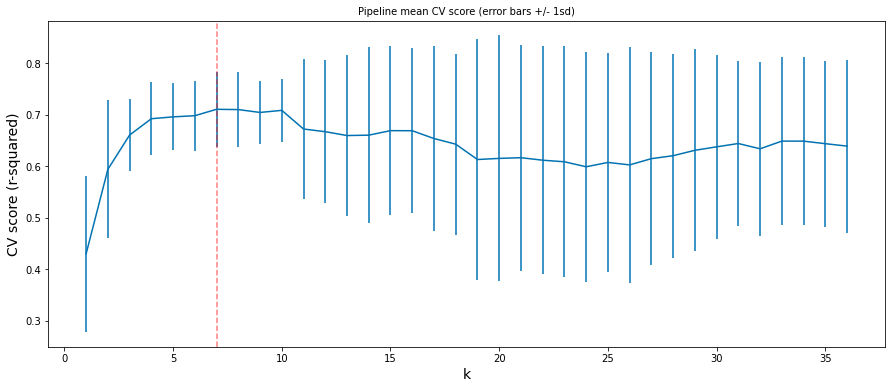

In [83]:
# Code task 20 #
# Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_["selectkbest__k"]
plt.subplots()
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c="r", ls="--", alpha=0.5)
plt.xlabel("k")
plt.ylabel("CV score (r-squared)")
plt.title("Pipeline mean CV score (error bars +/- 1sd)");

The above suggests a good value for k is 8. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results greatly increase above k=8. As you increasingly overfit, expect greater swings in performance as different points move in and out of the train/test folds.

Which features were most useful? Step into your best model, shown below. Starting with the fitted grid search object, you get the best estimator, then the named step 'selectkbest', for which you can its `get_support()` method for a logical mask of the features selected.

In [84]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

Similarly, instead of using the 'selectkbest' named step, you can access the named step for the linear regression model and, from that, grab the model coefficients via its `coef_` attribute:

In [85]:
# Code task 21 #
# Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
# get the matching feature names from the column names of the dataframe,
# and display the results as a pandas Series with `coefs` as the values and `features` as the index,
# sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
lin_mod_feat_imps = pd.Series(coefs, index=features).sort_values(ascending=False)
lin_mod_feat_imps

snow_making_ac    8.139313
vertical_drop     7.703800
fast_quads        6.324287
total_chairs      5.125146
longest_run_mi    2.194277
runs             -0.682407
trams            -2.267332
dtype: float64

These results suggest that vertical drop is your biggest positive feature. This makes intuitive sense and is consistent with what you saw during the EDA work. Also, you see the area covered by snow making equipment is a strong positive as well. People like guaranteed skiing! The skiable terrain area is negatively associated with ticket price! This seems odd. People will pay less for larger resorts? There could be all manner of reasons for this. It could be  an effect whereby larger resorts can host more visitors at any one time and so can charge less per ticket. As has been mentioned previously, the data are missing information about visitor numbers. Bear in mind,  the coefficient for skiable terrain is negative _for this model_. For example, if you kept the total number of chairs and fastQuads constant, but increased the skiable terrain extent, you might imagine the resort is worse off because the chairlift capacity is stretched thinner.

# Random Forest Model

A model that can work very well in a lot of cases is the random forest. For regression, this is provided by `sklearn`'s `RandomForestRegressor` class.

Time to stop the bad practice of repeatedly checking performance on the test split. Instead, go straight from defining the pipeline to assessing performance using cross-validation. `cross_validate` will perform the fitting as part of the process. This uses the default settings for the random forest so you'll then proceed to investigate some different hyperparameters.

## Define a pipeline

In [86]:
# Code task 22 #
# Define a pipeline comprising the steps:
# SimpleImputer() with a strategy of 'median'
# StandardScaler(),
# and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=RANDOM_SEED)
)

## Fit the pipeline using CV

In [87]:
# Code task 23 #
# Call `cross_validate` to estimate the pipeline's performance.
# Pass it the random forest pipe object, `X_train` and `y_train`,
# and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [88]:
rf_cv_scores = rf_default_cv_results["test_score"]
rf_cv_scores

array([0.6047725 , 0.76518362, 0.77108351, 0.65969584, 0.75344743])

In [89]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.710836580578581, 0.0667292148389386)

## Hyperparameter search using GridSearchCV

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [90]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
    "randomforestregressor__n_estimators": n_est,
    "standardscaler": [StandardScaler(), None],
    "simpleimputer__strategy": ["mean", "median"],
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [91]:
# Code task 24#
# Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
# dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [92]:
# Code task 25 #
# Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
# to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=51))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [93]:
# Code task 26 #
# Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 379,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

It looks like imputing with the median helps, but scaling the features doesn't.

In [94]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results["test_score"]
rf_best_scores

array([0.61857279, 0.78236869, 0.76339337, 0.67383321, 0.75644732])

In [95]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.7189230747150589, 0.062472872134423596)

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

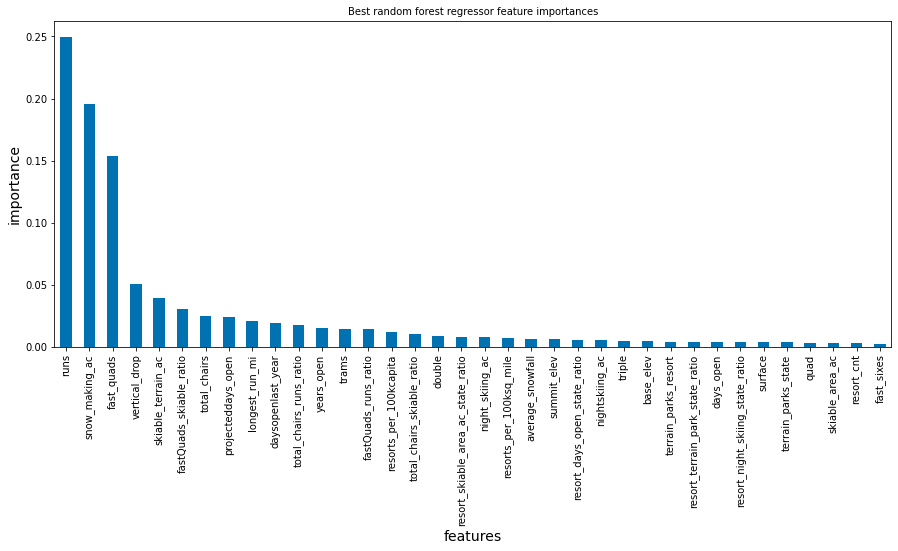

In [96]:
# Code task 27#
# Plot a barplot of the random forest's feature importances,
# assigning the `feature_importances_` attribute of
# `rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
# create a pandas Series object of the feature importances, with the index given by the
# training data column names, sorting the values in descending order
plt.subplots()
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind="bar")
plt.xlabel("features")
plt.ylabel("importance")
plt.title("Best random forest regressor feature importances");

Encouragingly, the dominant top four features are in common with your linear model:
* fastQuads
* Runs
* Snow Making_ac
* vertical_drop

<div class="alert alert-block alert-info">
<b>MY CUSTOM ADDITION -- SHOW IT!</b></div>

In [97]:
print(
    f'In Linear but not RF: {set(lin_mod_feat_imps.index[:5]).difference(set(rf_feat_imps.index[:5]))}'
)

In Linear but not RF: {'longest_run_mi', 'total_chairs'}


In [98]:
print(
    f'In RF but not Linear: {set(rf_feat_imps.index[:5]).difference(set(lin_mod_feat_imps.index[:5]))}'
)

In RF but not Linear: {'runs', 'skiable_terrain_ac'}


<div class="alert alert-block alert-info">
<b></b></div>

# Final Model Selection

Time to select your final model to use for further business modeling! It would be good to revisit the above model selection; there is undoubtedly more that could be done to explore possible hyperparameters.
It would also be worthwhile to investigate removing the least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed.
Building a simpler model with fewer features can also have the advantage of being easier to sell (and/or explain) to stakeholders.
Certainly there seem to be four strong features here and so a model using only those would probably work well.
However, you want to explore some different scenarios where other features vary so keep the fuller 
model for now. 
The business is waiting for this model and you have something that you have confidence in to be much better than guessing with the average price.

Or, rather, you have two "somethings". You built a best linear model and a best random forest model. You need to finally choose between them. You can calculate the mean absolute error using cross-validation. Although `cross-validate` defaults to the $R^2$ [metric for scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring) regression, you can specify the mean absolute error as an alternative via
the `scoring` parameter.

## Linear regression model performance

In [99]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(
    lr_grid_cv.best_estimator_,
    X_train,
    y_train,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)

In [100]:
lr_mae_mean = np.mean(-1 * lr_neg_mae["test_score"])
lr_mae_std = np.std(-1 * lr_neg_mae["test_score"])
lr_mae_mean, lr_mae_std

(10.0152550851037, 1.13678383497758)

In [101]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

10.890505849497153

## Random forest regression model performance

In [102]:
rf_neg_mae = cross_validate(
    rf_grid_cv.best_estimator_,
    X_train,
    y_train,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)

In [103]:
rf_mae_mean = np.mean(-1 * rf_neg_mae["test_score"])
rf_mae_std = np.std(-1 * rf_neg_mae["test_score"])
rf_mae_mean, rf_mae_std

(9.510072820216413, 0.7580746633741362)

In [104]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

10.1584634678654

## Conclusion

The random forest model has a lower cross-validation mean absolute error by almost \\$1. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

# Data quantity assessment

Finally, you need to advise the business whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [105]:
fractions = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.75, 0.8, 1.0]
train_size, train_scores, test_scores = learning_curve(
    pipe, X_train, y_train, train_sizes=fractions
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

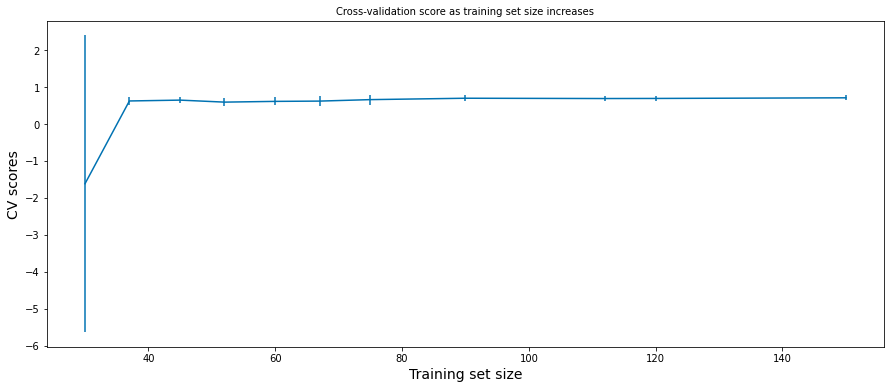

In [106]:
plt.subplots()
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel("Training set size")
plt.ylabel("CV scores")
plt.title("Cross-validation score as training set size increases");

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 40-50.

# Save best model object from pipeline

In [107]:
# Code task 28#
# This may not be "production grade ML deployment" practice, but adding some basic
# information to your saved models can save your bacon in development.
# Just what version model have you just loaded to reuse? What version of `sklearn`
# created it? When did you make it?
# Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
# the numpy version (`np.__version__`) to the `numpy_version` attribute,
# the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
# and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
# Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_
best_model.version = "1.0.0"
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [108]:
# save the model to disk
filename = '../models/ski_resort_pricing_model.joblib'
joblib.dump(best_model, filename)

['../models/ski_resort_pricing_model.joblib']

# Summary

**Q: 1** Write a summary of the work in this notebook. Capture the fact that you gained a baseline idea of performance by simply taking the average price and how well that did. Then highlight that you built a linear model and the features that found. Comment on the estimate of its performance from cross-validation and whether its performance on the test split was consistent with this estimate. Also highlight that a random forest regressor was tried, what preprocessing steps were found to be best, and again what its estimated performance via cross-validation was and whether its performance on the test set was consistent with that. State which model you have decided to use going forwards and why. This summary should provide a quick overview for someone wanting to know quickly why the given model was chosen for the next part of the business problem to help guide important business decisions.

**A: 1** Your answer here